# Code for axisymmetric  coupled thermoelasticity of elastomers

Contraction of a stretched rubber cylinder upon heating
This axi-symmetric simulation is performed  in two steps:
    
Step 1: Subject the cylinder to  a traction ramped from 0 to 2MPa
        on one of its end faces, while maintianing the
        temperature constant at 298K on its exterior faces
        
Step 2: While keeping the end traction constant, ramp
        up the boundary temperature from 298 to 348K
        
Degrees of freedom: \
vectorial displacement: u \
pressure: p \
temperature: theta

Basic units: \
Length: mm \
Mass: kg \
Time: s \
Mass density: kg/mm^3 \
Force: milliN \
Stress: kPa  \
Energy: microJ \
Temperature: K \
Boltzmann Constant: 1.38E-17 microJ/K \
Number of polymer chains per unit vol: #/mm^3 \
Thermal expansion coefficient: #/K \
Specific heat: microJ/(mm^3 K) \
Thermal conductivity: microW/(mm K) 

Eric Stewart and Lallit Anand   
ericstew@mit.edu and anand@mit.edu   

Converted to FEniCSx by Jorge Nin
jorgenin@mit.edu
September 2023



In [1]:
import numpy as np
import dolfinx

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, FunctionSpace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import XDMFFile
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional , gt, dx, inner, derivative, dot, ln, split)
from datetime import datetime
from dolfinx.plot import vtk_mesh

import pyvista
pyvista.set_jupyter_backend('client')
## Define temporal parameters

### Set level of detail for log messages (integer)
Guide: \
CRITICAL  = 50  errors that may lead to data corruption \
ERROR     = 40  things that HAVE gone wrong \
WARNING   = 30  things that MAY go wrong later \
INFO      = 20  information of general interest (includes solver info) \
PROGRESS  = 16  what's happening (broadly) \
TRACE     = 13  what's happening (in detail) \
DBG       = 10  sundry 


In [2]:
log.set_log_level(log.LogLevel.WARNING)

# Define Geometry

In [3]:
name = "results/Axi_thermoelas_steps"
R0 = 10.0 # Radius
H0 = 10.0 #height
domain = mesh.create_rectangle(MPI.COMM_WORLD,[[0.0,0.0],[R0,H0]],[5,5])

### Visualize Gemometry

In [4]:
plotter = pyvista.Plotter()
vtkdata = vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(*vtkdata)
actor = plotter.add_mesh(grid, show_edges=True)
plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:60202/index.html?ui=P_0x2abe76c90_0&reconnect=auto' style='width: …

## Functions for finding Differnent Areas

In [5]:
def Left(x):
    return np.isclose(x[0], 0)
def Right(x):
    return np.isclose(x[0], R0)
def Bottom(x):
    return np.isclose(x[1], 0)
def Top(x):
    return np.isclose(x[1], H0)

def Ground(x):
        return np.isclose(x[0],0) and  np.isclose(x[1], 0)


In [6]:
boundaries = [(1, Left),(2,Bottom),(3,Right),(4,Top)]

facet_indices, facet_markers = [], []
fdim = domain.topology.dim-1
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)

facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tag,metadata={'quadrature_degree': 4})
n = ufl.FacetNormal(domain)

## Simulation Control

In [7]:
t    = 0.0       

dt   = 2            # Fixed  time step size
step1_time =50
step2_time = 250
step2_ramp = 50
Ttot = step1_time + step2_time
# Maximum end displalcement
#uMax = 6 #mm
trac_max = 2000 #mm

# Expression  defining  displacement history
def uRamp(t):
    return min(trac_max*t/step1_time,trac_max)

## Function Spaces

$$ \frac{x}{y}$$


In [8]:
U2 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 2) # For displacement
P1 = ufl.FiniteElement("Lagrange", domain.ufl_cell(), 1) # For  pressure
TH = ufl.MixedElement([U2, P1,P1])     # Taylor-Hood style mixed element
ME = FunctionSpace(domain, TH)    # Total space for all DOFs

In [9]:
w = Function(ME)
u, p, theta= split(w)
w_old         = Function(ME)
u_old,  p_old, theta_old = split(w_old)

u_test, p_test, theta_test = TestFunctions(ME)       
dw = TrialFunction(ME)     

## SubRoutine

In [10]:
from subroutines import *
relations = ThermoElasticAxialSymmetric(u,p,theta,u_old,p_old,theta_old,domain)

In [11]:
#Initialize Temperatures
w.sub(2).interpolate(lambda x: np.full((x.shape[1],),  relations.theta0))
w_old.sub(2).interpolate(lambda x: np.full((x.shape[1],),  relations.theta0))

## WEAK FORMS

In [12]:
dxs = dx(metadata={'quadrature_degree': 4})

In [13]:
Tmat,J =relations.Kinematics()

dk = Constant(domain,PETSc.ScalarType(dt))
# Residuals:
# Res_0: Balance of forces (test fxn: u)
# Res_1: Coupling pressure (test fxn: p)
tracRamp = Constant(domain,PETSc.ScalarType(uRamp(0)))
traction = as_vector([0, tracRamp])

# The weak form for the equilibrium equation. No body force
Res_0 = inner(Tmat , relations.ax_grad_vector(u_test) )*relations.x[0]*dxs \
        - dot(traction, u_test)*relations.x[0]*ds(4)

# The weak form for the pressure
fac_p =  ( ln(J) - 3*relations.alpha*(theta-relations.theta0) )/J
#
Res_1 = dot( (p/relations.Kbulk + fac_p), p_test)*relations.x[0]*dxs

# The weak form for heat equation
Res_2 = dot(relations.c_v*(theta - theta_old), theta_test)*relations.x[0]*dxs \
        -  (1/2)*theta * inner(relations.M, (relations.C - relations.C_old)) * theta_test*relations.x[0]*dxs \
        -  dk*dot(relations.Qmat , relations.ax_grad_scalar(theta_test) )*relations.x[0]*dxs

# Total weak form
Res = Res_0 +  Res_1 + Res_2 

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

In [14]:
Time_cons = Constant(domain,PETSc.ScalarType(0.0))

#U0, submap = ME.sub(0).sub(1).collapse()
#fixed_displacement = fem.Function(U0)
#fixed_displacement.interpolate(lambda x :   np.full(x.shape[1], distRamp(Time_cons)))

dofs_1 = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tag.dim, facet_tag.find(1))
dofs_2 = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tag.dim, facet_tag.find(2))

dofs_3 = fem.locate_dofs_topological(ME.sub(2), facet_tag.dim, facet_tag.find(2))
dofs_4 = fem.locate_dofs_topological(ME.sub(2), facet_tag.dim, facet_tag.find(3))
dofs_5 = fem.locate_dofs_topological(ME.sub(2), facet_tag.dim, facet_tag.find(4))



bcs_1 = dirichletbc(0.0, dofs_1,ME.sub(0).sub(0))  # u1 fix - xBot
bcs_2 = dirichletbc(0.0, dofs_2, ME.sub(0).sub(1))  # u2 fix - yBot
bcs_3 = dirichletbc(relations.theta0,dofs_3 ,ME.sub(2))  # u3 fix - zBot
bcs_4 = dirichletbc(relations.theta0,dofs_4 ,ME.sub(2))  # u3 fix - zBot

bcs_5 = dirichletbc(relations.theta0,dofs_5 ,ME.sub(2))  # u3 fix - zBot

#
bcs = [bcs_1, bcs_2, bcs_3,bcs_4,bcs_5]

Second set of BCS for problem 2


In [15]:
def thetaRamp(t):
    if t>= step1_time:
        return min(relations.theta0.value + 50*(t-step1_time)/step2_ramp,relations.theta0.value+50)
    else:
        return relations.theta0

TempRamp = Constant(domain,PETSc.ScalarType(thetaRamp(t)))

#U0, submap = ME.sub(0).sub(1).collapse()
#fixed_displacement = fem.Function(U0)
#fixed_displacement.interpolate(lambda x :   np.full(x.shape[1], distRamp(Time_cons)))

dofs_1 = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tag.dim, facet_tag.find(1))
dofs_2 = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tag.dim, facet_tag.find(2))

dofs_3 = fem.locate_dofs_topological(ME.sub(2), facet_tag.dim, facet_tag.find(2))
dofs_4 = fem.locate_dofs_topological(ME.sub(2), facet_tag.dim, facet_tag.find(3))
dofs_5 = fem.locate_dofs_topological(ME.sub(2), facet_tag.dim, facet_tag.find(4))



bcs_1 = dirichletbc(0.0, dofs_1,ME.sub(0).sub(0))  # u1 fix - xBot
bcs_2 = dirichletbc(0.0, dofs_2, ME.sub(0).sub(1))  # u2 fix - yBot
bcs_3 = dirichletbc(TempRamp,dofs_3 ,ME.sub(2))  # u3 fix - zBot
bcs_4 = dirichletbc(TempRamp,dofs_4 ,ME.sub(2))  # u3 fix - zBot

bcs_5 = dirichletbc(TempRamp,dofs_5 ,ME.sub(2))  # u3 fix - zBot

#
bcs2 = [bcs_1, bcs_2, bcs_3,bcs_4,bcs_5]

## Non Linear Variational

In [16]:
#Setting up visualziation
import pyvista
import matplotlib
import cmasher as cmr
import os

if not os.path.exists("results"):

   # Create a new directory because it does not exist
   os.makedirs("results")


pyvista.set_jupyter_backend('client')
plotter = pyvista.Plotter()
plotter.open_gif(name+".gif")


V = fem.FunctionSpace(domain,U2) ## Difference 
u_n = fem.Function(V)
u_ex = Expression(w.sub(0),V.element.interpolation_points())
u_n.interpolate(u_ex)


topology, cells, geometry = plot.vtk_mesh(u_n.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
values = np.zeros((geometry.shape[0], 3))
#u0 = w.sub(0).collapse()
values[:, :len(u_n)] = u_n.x.array.reshape(geometry.shape[0], len(u_n))

function_grid["u"] = values
function_grid.set_active_vectors("u")


# Warp mesh by deformation
warped = function_grid.warp_by_vector("u", factor=0)
warped.set_active_vectors("u")


cmap = cmr.get_sub_cmap(matplotlib.colormaps.get_cmap("jet"), 0.1, 0.9,N=50)
# Add mesh to plotter and visualize
actor = plotter.add_mesh(warped, show_edges=True, lighting=False, clim=[293, 350],cmap=cmap)

# Compute magnitude of displacement to visualize in GIF 
Vs = fem.FunctionSpace(domain, ("Lagrange", 2))
magnitude = fem.Function(Vs)
us = fem.Expression(w.sub(2), Vs.element.interpolation_points())
magnitude.interpolate(us)
warped["mag"] = magnitude.x.array

plotter.view_xy()
plotter.camera.position=[5,25,200]
plotter.camera.focal_point=[5,40,0]
plotter.write_frame()



In [17]:
## Functions for visualization


U1 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 1)
V2 = fem.FunctionSpace(domain, U1)#Vector function space
V1 = fem.FunctionSpace(domain, P1)#Scalar function space

u_r = Function(V2)
u_r.name = "disp"

p_r = Function(V1)
p_r.name = "p"

theta_r = Function(V1)
theta_r.name="theta"

J_vis = Function(V1)
J_vis.name = "J"
J_expr = Expression(J,V1.element.interpolation_points())


lambdaBar_Vis = Function(V1)
lambdaBar_Vis.name = "lambdaBar"
lambdaBar_expr = Expression(relations.lambdaBar,V1.element.interpolation_points())

 # Visualize M:Cdot
MCdotExpr = Expression(inner(relations.M, (relations.C-relations.C_old)/dt),V1.element.interpolation_points())

MCdot_Vis = Function(V1)
MCdot_Vis.name = "M:Cdot"

delta_theta_vis = Function(V1)
delta_theta_Exp=Expression(theta -relations.theta0,V1.element.interpolation_points())
delta_theta_vis.name = "Delta Theta"

P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Tmat[0,0],V1.element.interpolation_points())
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Tmat[1,1],V1.element.interpolation_points())
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Tmat[2,2],V1.element.interpolation_points())

T   = Tmat*relations.F.T/J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_Vis= Function(V1,name="Mises")
Mises_expr = Expression(Mises,V1.element.interpolation_points())

def InterpAndSave(t,file):
    u_r.interpolate(w.sub(0))
    p_r.interpolate(w.sub(1))
    theta_r.interpolate(w.sub(2))
    delta_theta_vis.interpolate(delta_theta_Exp)
    J_vis.interpolate(J_expr)
    P11.interpolate(P11_expr)
    P22.interpolate(P22_expr)
    P33.interpolate(P33_expr)
    lambdaBar_Vis.interpolate(lambdaBar_expr)
    Mises_Vis.interpolate(Mises_expr)
    MCdot_Vis.interpolate(MCdotExpr)

    file.write_function(u_r,t)
    file.write_function(p_r,t)
    file.write_function(theta_r,t)
    file.write_function(delta_theta_vis,t)
    file.write_function(J_vis,t)
    file.write_function(P11,t)
    file.write_function(P22,t)
    file.write_function(P33,t)
    file.write_function(lambdaBar_Vis,t)
    file.write_function(Mises_Vis,t)
    file.write_function(MCdot_Vis,t)


pointForStress = [0,H0,0]
bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForStress)
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForStress)
 

engineeringStress= fem.form(2*np.pi*relations.x[0]*P22*ds(4)) #P22/area*ds

In [18]:

startTime = datetime.now()
step = "Step 1 "
jit_options ={"cffi_extra_compile_args":["-O3","-ffast-math"]}



problem = NonlinearProblem(Res, w, bcs, a)


solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
#opts[f"{option_prefix}ksp_type"] = "preonly"
#opts[f"{option_prefix}pc_type"] = "lu"
#opts[f"{option_prefix}pc_hypre_type"] = "boomeramg"
#opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

# Initialize time history variables.
siz  = 100000 
Forc = np.zeros([siz+1,4])
Forc[0,3] = relations.theta0  # initial temp


ii   = 1 # counter 

if os.path.exists(name+".xdmf"):
    os.remove(name+".xdmf")
    os.remove(name+".h5")
xdmf = XDMFFile(domain.comm, name+".xdmf", "w")
xdmf.write_mesh(domain)



InterpAndSave(t,xdmf)


print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()
#log.set_log_level(log.LogLevel.INFO)
ii = 0
while (t < step1_time):
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    tracRamp.value = uRamp(t)
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        print( "Ended Early")
        break

    w.x.scatter_forward()
    # Write output to *.xdmf file
    #writeResults(t)
    #print(u0.x.array-w.x.array[dofs])

    #Visualizing GIF
    u_n.interpolate(u_ex)
    function_grid["u"][:, :len(u_n)] = u_n.x.array.reshape(geometry.shape[0], len(u_n))
   
    magnitude.interpolate(us)
    warped.set_active_scalars("mag")
    warped_n = function_grid.warp_by_vector(factor=1)
    plotter.update_coordinates(warped_n.points.copy(), render=False)
    plotter.update_scalars(magnitude.x.array,render = False)
    
    plotter.write_frame()

    # Update DOFs for next step
    w_old.x.array[:] = w.x.array


    #SAVING RESULT
    InterpAndSave(t,xdmf)

    # Store  displacement at a particular point  at this time
    Forc[ii,0] =  w.sub(0).sub(1).eval(pointForStress,colliding_cells[0])[0]
    #
    Forc[ii,1] = domain.comm.gather(fem.assemble_scalar(engineeringStress))[0]
    Forc[ii,2] = t
    Forc[ii,3] = w.sub(2).eval(pointForStress,colliding_cells[0])[0]
    
    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Simulation Time: {} s, Wallclock Time: {}".\
              format(step, round(t,4), current_time))
        print("Iterations: {}".format(iter))
        print()  


"""""""""""""""""
      STEP 2
"""""""""""""""""
      
# Give the second step a descriptive name
step = "Step 2"





problem = NonlinearProblem(Res, w, bcs2, a)


solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
#opts[f"{option_prefix}ksp_type"] = "preonly"
#opts[f"{option_prefix}pc_type"] = "lu"
#opts[f"{option_prefix}pc_hypre_type"] = "boomeramg"
#opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()


while (t < step1_time + step2_time):
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    tracRamp.value = uRamp(t)
    TempRamp.value = thetaRamp(t)
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        print( "Ended Early")
        break

    w.x.scatter_forward()
    # Write output to *.xdmf file
    #writeResults(t)
    #print(u0.x.array-w.x.array[dofs])

    #Visualizing GIF
    u_n.interpolate(u_ex)
    function_grid["u"][:, :len(u_n)] = u_n.x.array.reshape(geometry.shape[0], len(u_n))
   
    magnitude.interpolate(us)
    warped.set_active_scalars("mag")
    warped_n = function_grid.warp_by_vector(factor=1)
    plotter.update_coordinates(warped_n.points.copy(), render=False)
    plotter.update_scalars(magnitude.x.array,render = False)
    
    plotter.write_frame()

    # Update DOFs for next step
    w_old.x.array[:] = w.x.array


    #SAVING RESULT
    InterpAndSave(t,xdmf)

    # Store  displacement at a particular point  at this time
    Forc[ii,0] =  w.sub(0).sub(1).eval(pointForStress,colliding_cells[0])[0]
    #
    Forc[ii,1] = domain.comm.gather(fem.assemble_scalar(engineeringStress))[0]
    Forc[ii,2] = t
    Forc[ii,3] = w.sub(2).eval(pointForStress,colliding_cells[0])[0]
   
    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Simulation Time: {} s, Wallclock Time: {}".\
              format(step, round(t,4), current_time))
        print("Iterations: {}".format(iter))
        print()  



plotter.close()
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")
xdmf.close()

------------------------------------
Simulation Start
------------------------------------
Step: Step 1  | Simulation Time: 2.0 s, Wallclock Time: 19:54:08
Iterations: 5

Step: Step 1  | Simulation Time: 4.0 s, Wallclock Time: 19:54:08
Iterations: 5

Step: Step 1  | Simulation Time: 6.0 s, Wallclock Time: 19:54:08
Iterations: 5

Step: Step 1  | Simulation Time: 8.0 s, Wallclock Time: 19:54:08
Iterations: 5

Step: Step 1  | Simulation Time: 10.0 s, Wallclock Time: 19:54:08
Iterations: 5

Step: Step 1  | Simulation Time: 12.0 s, Wallclock Time: 19:54:08
Iterations: 5

Step: Step 1  | Simulation Time: 14.0 s, Wallclock Time: 19:54:08
Iterations: 5

Step: Step 1  | Simulation Time: 16.0 s, Wallclock Time: 19:54:08
Iterations: 5

Step: Step 1  | Simulation Time: 18.0 s, Wallclock Time: 19:54:08
Iterations: 4

Step: Step 1  | Simulation Time: 20.0 s, Wallclock Time: 19:54:08
Iterations: 4

Step: Step 1  | Simulation Time: 22.0 s, Wallclock Time: 19:54:08
Iterations: 4

Step: Step 1  | Simula

In [19]:
thetaRamp(t)

348.0

In [20]:
#[[0.9668117567818925,0,0],[1.5265566588595902e-16,1.07,0]]

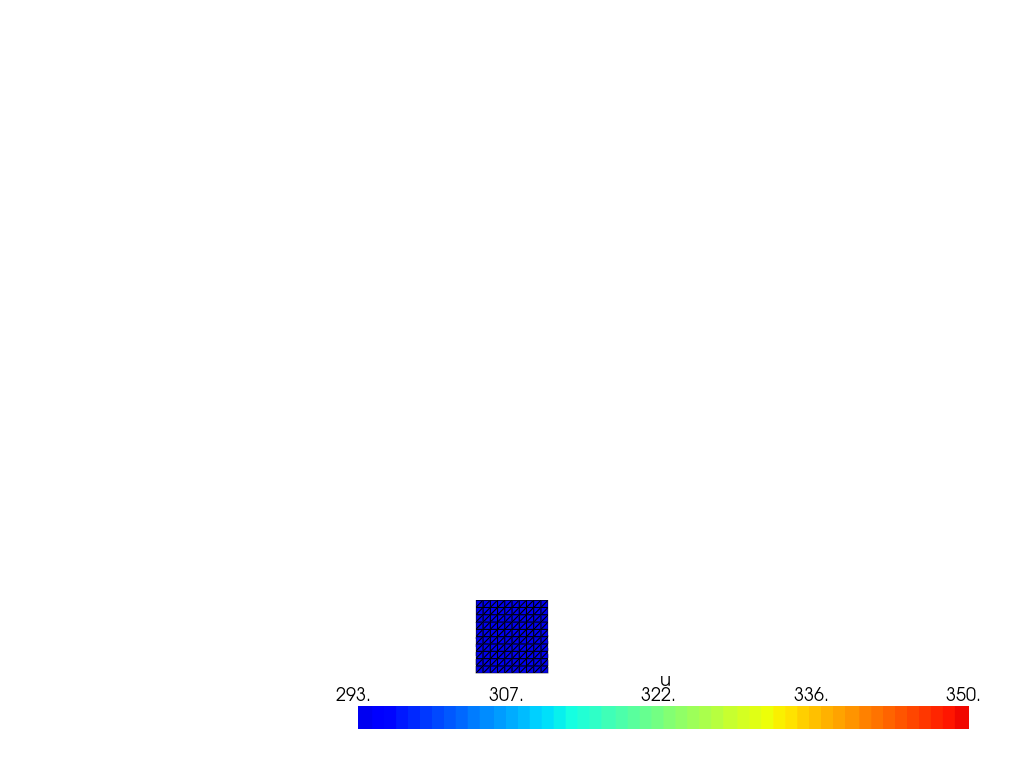

In [21]:
from IPython.display import Image
display(Image(data=open(name+".gif",'rb').read(), format='png'))

In [22]:
pyvista.set_jupyter_backend('client')
plotter = pyvista.Plotter()

V = fem.VectorFunctionSpace(domain,("Lagrange",2))
u_n = fem.Function(V)
u_ex = Expression(w.sub(0),V.element.interpolation_points())
u_n.interpolate(u_ex)

topology, cells, geometry = plot.vtk_mesh(V)

function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
values = np.zeros((geometry.shape[0], 3))
values[:, :len(u_n)] = u_n.x.array.reshape(geometry.shape[0], len(u_n))

function_grid["u"] = values
function_grid.set_active_vectors("u")

warped = function_grid.warp_by_vector("u", factor=1)
warped.set_active_vectors("u")

# Add mesh to plotter and visualize
actor = plotter.add_mesh(warped, show_edges=True, lighting=False, clim=[0, 67.5])

# Compute magnitude of displacement to visualize in GIF 
Vs = FunctionSpace(domain,("Lagrange", 2))
magnitude = fem.Function(Vs)
us = fem.Expression(u_n[1], Vs.element.interpolation_points())
magnitude.interpolate(Mises_Vis)
warped["mag"] = magnitude.x.array
#print(u_n.function_space.dofmap.list)
plotter.update_scalars(magnitude.x.array,render = False)
#plotter.camera.position=[5,25,200]
#plotter.camera.focal_point=[5,40,0]
plotter.render()
plotter.show()


  V = fem.VectorFunctionSpace(domain,("Lagrange",2))



Widget(value="<iframe src='http://localhost:60202/index.html?ui=P_0x2abf03ad0_0&reconnect=auto' style='width: …

In [23]:
Mises_Vis.x.array

array([9442.28018567, 9443.34810598, 9443.89645619, 9442.71716171,
       9440.53586537, 9444.6095107 , 9441.72311526, 9443.50839559,
       9438.94725727, 9444.4253235 , 9440.86150118, 9443.04101949,
       9443.4581856 , 9437.80511571, 9442.96067229, 9440.29858775,
       9442.80334076, 9443.25050756, 9442.42009324, 2276.62790051,
       9440.85377941, 2276.423828  , 9442.66089859, 9443.28677384,
       9442.38121109, 9441.05999427, 2276.31243613, 9443.34478896,
       9442.4793782 , 9441.24926231, 2276.4068622 , 9442.56612356,
       9441.38707604, 2276.58414255, 9441.49332666, 2277.29222868])

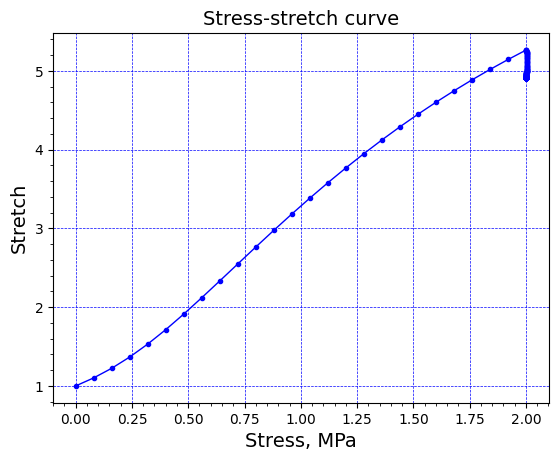

<Figure size 700x500 with 0 Axes>

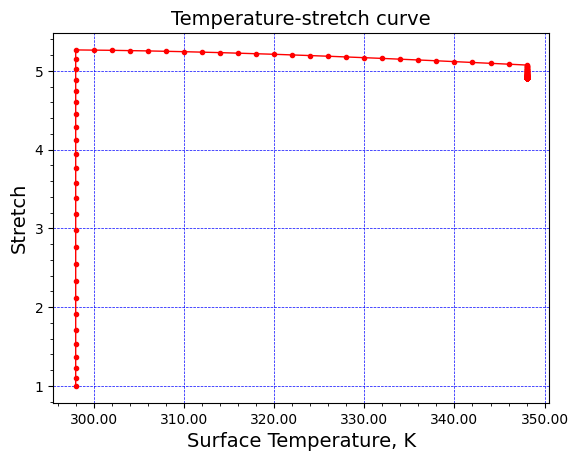

<Figure size 700x500 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt

prop_cycle = plt.rcParams['axes.prop_cycle']
colors     = prop_cycle.by_key()['color']

# Only plot as far as time history data
ind = np.argmax(Forc[:,2])
   
# Create figure for stress-stetch curve.
#
fig = plt.figure() 
ax=fig.gca()  
plt.plot( Forc[0:ind,1]/(np.pi*R0*R0)/1000, (Forc[0:ind,0]/H0 +1), c='b', linewidth=1.0, marker='.')
#-----------------------------------------------------
plt.grid(linestyle="--", linewidth=0.5, color='b')
ax.set_xlabel("Stress, MPa",size=14)
ax.set_ylabel("Stretch",size=14)
ax.set_title("Stress-stretch curve", size=14, weight='normal')
#
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#plt.legend()
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.show()
# Save figure to file
fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/axi_stress_stretch.png", dpi=600) 


# Create figure for temperature-stretch curve.
#
fig = plt.figure() 
ax=fig.gca()  
plt.plot( Forc[0:ind,3], (Forc[0:ind,0]/H0 +1), c='r', linewidth=1.0, marker='.')
#----------------------------------------------------------------------------
plt.grid(linestyle="--", linewidth=0.5, color='b')
ax.set_xlabel("Surface Temperature, K",size=14)
ax.set_ylabel("Stretch",size=14)
ax.set_title("Temperature-stretch curve", size=14, weight='normal')
#
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#plt.legend()
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.show()
# Save figure to file
fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/axi_temp_stretch.png", dpi=600) 



 